# lambda cdm

In [78]:
from classy import Class
import numpy as np
LambdaCDM = Class()
ln_10_10_As = 3.044
A_s = np.exp(ln_10_10_As) / 1e10
# A_s = 3.044e-10

# 1807.06209 table 2, TT,TE,EE+lowE+lensing 
LambdaCDM.set({'omega_b':0.02237,
               'omega_cdm':0.1200,
               '100theta_s':1.04092,
               'A_s':A_s,
               'n_s':0.9649,
               'tau_reio':0.0544,
               'N_mscf':0,
               "do_shooting": "yes",
               }
               )

LambdaCDM.set({'output':'tCl,pCl,lCl,mPk','lensing':'yes'})

LambdaCDM.compute()


cl_tot = LambdaCDM.raw_cl(2500)

ell = cl_tot['ell']
T_cmb = 2.725
T_uK = T_cmb*1e6
D_ell_0 = ell*(ell+1)/(2*np.pi) * cl_tot['tt'] 
bg = LambdaCDM.get_background()
z_lcdm = bg['z'] #redshift
H_lcdm = bg['H [1/Mpc]'] #hubble rate

NPTS = 500  # choose 100, 200, 300… depending on how small you want the file

idx = np.round(np.linspace(0, len(z_lcdm) - 1, NPTS)).astype(int)

z_small_lcdm       = z_lcdm[idx]
H_small_lcdm  = H_lcdm[idx]

# multi-axion

In [79]:
# call this from terminal to sync
# rsync -avz --progress bella@lupm-slurm.lupm.in2p3.fr:/home/bella/mini_reconstruction_tool ~/uni/1_master_thesis/tools/output_remote


import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


def extract_residuals(dir):
    # -----------------------------
    # ️ Loop over samples and collect data
    # -----------------------------
    npz_files = sorted(dir.glob("*_sample_*.npz"))
    all_z = []
    all_fEDE = []
    all_H =[]
    all_ell = []
    all_cl_tt = []
    weights = []

    for npz_file in npz_files:
        data = np.load(npz_file)
        all_z.append(data["z"])
        all_fEDE.append(data["f_EDE"])
        all_H.append(data["H"])
        all_ell.append(data["ell"])
        all_cl_tt.append(data["cl_tt"])
        weights.append(data["weight"])

    weights=np.array(weights)

    # -----------------------------
    #  Plot f_EDE(z)
    # -----------------------------
    # plt.figure(figsize=(6,4))
    # for i, fEDE in enumerate(all_fEDE):
    #     plt.plot(all_z[i], fEDE, label=f"Sample {i}", alpha=0.7)
    # plt.xlabel("z")
    # plt.ylabel("f_EDE(z)")
    # plt.title("Early Dark Energy Fraction")
    # plt.yscale("linear")
    # plt.xscale("log")
    # #plt.legend()
    # plt.xlim(10**2,10**5)
    # plt.tight_layout()
    # plt.show()

    # # -----------------------------
    # # 4 Plot H(z)
    # # -----------------------------
    # plt.figure(figsize=(6,4))
    # for i, H in enumerate(all_H):
    #     plt.plot(all_z[i], H, label=f"Sample {i}", alpha=0.7)
    # plt.xlabel("z")
    # plt.ylabel("H(z)")
    # plt.title("Hubble r8")
    # plt.yscale("log")
    # plt.xscale("log")
    # #plt.legend()
    # plt.tight_layout()
    # plt.show()

    # -----------------------------
    #  Plot Cl_tt
    # -----------------------------
    # plt.figure(figsize=(6,4))
    # for i, cl in enumerate(all_cl_tt):
    #     ell = all_ell[i]
    #     D_tt = ell*(ell+1)*cl/(2*np.pi)
    #     plt.plot(ell, D_tt, label=f"Sample {i}", alpha=0.7)
    # plt.xlabel(r"$\ell$")
    # plt.ylabel(r"$D_\ell^{TT}$ [$\mu K^2$]")
    # plt.title("CMB TT Power Spectra")

    # Convert lists to arrays
    ell = all_ell[0]  # assume same ell grid for all samples

    # shape: (n_samples, n_ell)
    D_tt_all = np.array([
        ell*(ell+1)*cl/(2*np.pi) for cl in all_cl_tt
    ])


    residuals = D_tt_all  # ΔD_ell = sample - LCDM
    plt.figure(figsize=(6,4))
    # print(residuals)

    # from scipy.interpolate import interp1d

    residuals = (D_tt_all - D_ell_0 )/ D_ell_0

    n_samples, n_ell = residuals.shape
    # weights = np.ones(n_samples)   # or real MCMC weights

    # lower_68 = np.percentile(residuals, 16, axis=0)
    # upper_68 = np.percentile(residuals, 84, axis=0)
    # lower_95 = np.percentile(residuals, 2.5, axis=0) 
    # upper_95 = np.percentile(residuals, 97.5, axis=0)
    lower_68 = np.zeros(n_ell)
    upper_68 = np.zeros(n_ell)
    lower_95 = np.zeros(n_ell)
    upper_95 = np.zeros(n_ell)

    for j in range(n_ell):
        vals = residuals[:, j]

        lower_68[j], upper_68[j] = weighted_percentile(
            vals, weights, [16, 84]
        )
        lower_95[j], upper_95[j] = weighted_percentile(
            vals, weights, [2.5, 97.5]
        )
    return lower_95, lower_68, upper_68, upper_95

def weighted_percentile(values, weights, percentiles):
    """
    values: (N_samples,)
    weights: (N_samples,)
    percentiles: list or array in [0, 100]
    """
    sorter = np.argsort(values)
    values = values[sorter]
    weights = weights[sorter]

    cdf = np.cumsum(weights)
    cdf /= cdf[-1]

    return np.interp(np.array(percentiles) / 100.0, cdf, values)


def extract_bf(bf_file):
    bf_z = []
    bf_fEDE = []
    bf_H =[]
    bf_ell = []
    bf_cl_tt = []

    data = np.load(str(bf_file))
    bf_z= (data["z"])
    bf_fEDE= (data["f_EDE"])
    bf_H= (data["H"])
    bf_ell= (data["ell"])
    bf_cl_tt= (data["cl_tt"])
    D_tt_bf = np.array(bf_ell*(bf_ell+1)*bf_cl_tt/(2*np.pi))
    residuals_bf = (D_tt_bf - D_ell_0 )/ D_ell_0  # ΔD_ell = sample - LCDM
    residuals_bf_H = (bf_H - H_small_lcdm )/ H_small_lcdm  # ΔD_ell = sample - LCDM
    return residuals_bf, residuals_bf_H, bf_fEDE

def extract_bg(dir):
    # -----------------------------
    # ️ Loop over samples and collect data
    # -----------------------------
    all_z = []
    all_fEDE = []
    all_H =[]
    all_ell = []
    all_cl_tt = []
    weights = []
    npz_files = sorted(dir.glob("*_sample_*.npz"))

    for npz_file in npz_files:
        data = np.load(npz_file)
        all_z.append(data["z"])
        all_fEDE.append(data["f_EDE"])
        all_H.append(data["H"])
        all_ell.append(data["ell"])
        all_cl_tt.append(data["cl_tt"])
        weights.append(data["weight"])

    all_fEDE = np.array(all_fEDE)      # shape: (N_samples, N_z)
    all_H = np.array(all_H)      # shape: (N_samples, N_z)
    weights = np.array(weights)
    # weights = np.ones(n_samples)   # or real MCMC weights

    # lower_68 = np.percentile(residuals, 16, axis=0)
    # upper_68 = np.percentile(residuals, 84, axis=0)
    # lower_95 = np.percentile(residuals, 2.5, axis=0) 
    # upper_95 = np.percentile(residuals, 97.5, axis=0)
    lower_68 = np.zeros(all_fEDE.shape[1])
    upper_68 = np.zeros_like(lower_68)
    lower_95 = np.zeros_like(lower_68)
    upper_95 = np.zeros_like(lower_68)
    for j in range(all_fEDE.shape[1]):
        vals = all_fEDE[:, j]
        w = weights

        lower_68[j], upper_68[j] = weighted_percentile(vals, w, [16, 84])
        lower_95[j], upper_95[j] = weighted_percentile(vals, w, [2.5, 97.5])

    lower_68_H = np.zeros(all_H.shape[1])
    upper_68_H = np.zeros_like(lower_68)
    lower_95_H = np.zeros_like(lower_68)
    upper_95_H = np.zeros_like(lower_68)

    for j in range(all_H.shape[1]):  # loop over z
        vals = (all_H[:, j] - H_small_lcdm[j])/H_small_lcdm[j]
        w = weights

        lower_68_H[j], upper_68_H[j] = weighted_percentile(vals, w, [16, 84])
        lower_95_H[j], upper_95_H[j] = weighted_percentile(vals, w, [2.5, 97.5])
    return all_z, [lower_95, lower_68, upper_68, upper_95], [lower_95_H, lower_68_H, upper_68_H, upper_95_H]


In [80]:
# -----------------------------
#2pd
# -----------------------------
data_dir = "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/2pd/output_class/"
dir = Path(data_dir)  # adjust path if needed
bf_file = data_dir+ "bestfit.npz"

lower_95_2pd, lower_68_2pd, upper_68_2pd, upper_95_2pd = extract_residuals(dir)
all_z_2pd, ci_fede_2pd, ci_h_2pd = extract_bg(dir)

residuals_bf_2pd, residuals_bf_H_2pd, f_ede_2pd  = extract_bf(bf_file)

# -----------------------------
#2psd
# -----------------------------
data_dir = "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/2psd/output_class/"
dir = Path(data_dir)  # adjust path if needed
bf_file =data_dir+ "bestfit.npz"

lower_95_2psd, lower_68_2psd, upper_68_2psd, upper_95_2psd = extract_residuals(dir)
residuals_bf_2psd, residuals_bf_H_2psd, f_ede_2psd  = extract_bf(bf_file)
all_z_2psd, ci_fede_2psd, ci_h_2psd = extract_bg(dir)

/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_36750/2492502995.py:91: RuntimeWarning: invalid value encountered in divide
  residuals = (D_tt_all - D_ell_0 )/ D_ell_0
/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_36750/2492502995.py:146: RuntimeWarning: invalid value encountered in divide
  residuals_bf = (D_tt_bf - D_ell_0 )/ D_ell_0  # ΔD_ell = sample - LCDM


<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

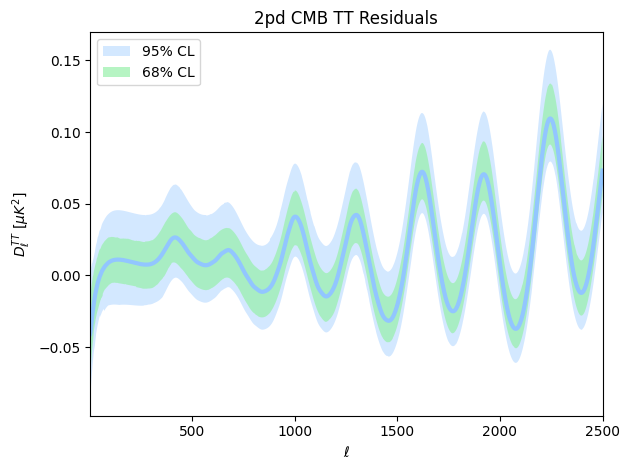

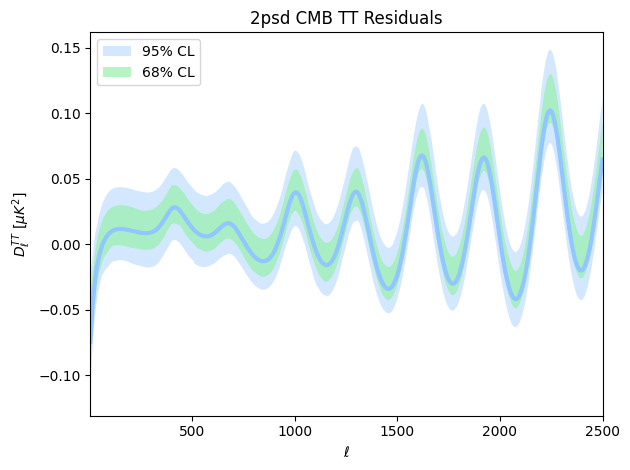

In [81]:

plt.plot(ell, residuals_bf_2pd, linewidth=3)
plt.fill_between(
    ell, lower_95_2pd, upper_95_2pd,
    alpha=0.4, label="95% CL"
)

plt.fill_between(
    ell, lower_68_2pd, upper_68_2pd,
    alpha=0.7, label="68% CL"
)

plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell^{TT}$ [$\mu K^2$]")
plt.title("2pd CMB TT Residuals")
plt.xlim(2, 2500)
# plt.ylim(0,0.1)
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(ell, residuals_bf_2psd, linewidth=3)
plt.fill_between(
    ell, lower_95_2psd, upper_95_2psd,
    alpha=0.4, label="95% CL"
)

plt.fill_between(
    ell, lower_68_2psd, upper_68_2psd,
    alpha=0.7, label="68% CL"
)

plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell^{TT}$ [$\mu K^2$]")
plt.title("2psd CMB TT Residuals")
plt.xlim(2, 2500)
# plt.ylim(0,0.1)
plt.legend()
plt.tight_layout()
plt.show()

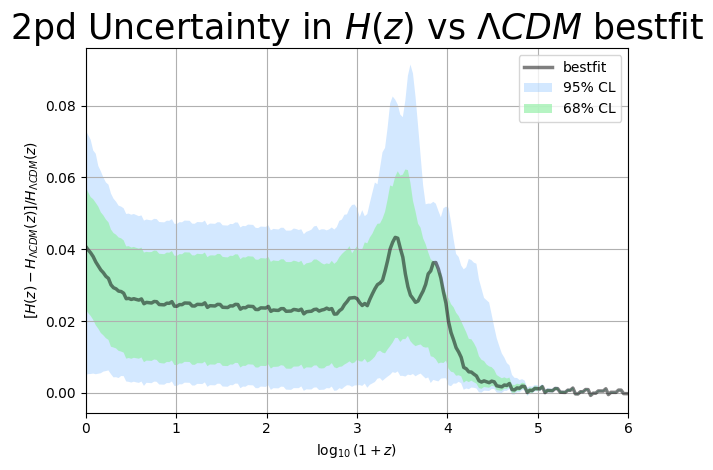

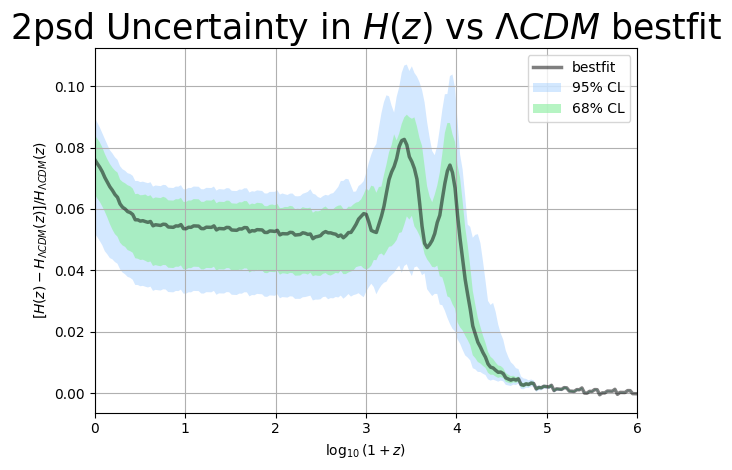

In [82]:
plt.plot(np.log10(1 + all_z_2pd[0]), residuals_bf_H_2pd, color='black',alpha=0.5, lw=2.5, label="bestfit")
# 95% confidence interval
# 68% confidence interval
# Median line
plt.fill_between(np.log10(1 + all_z_2pd[0]), ci_h_2pd[0], ci_h_2pd[3], alpha=0.4,label="95% CL")
plt.fill_between(np.log10(1 + all_z_2pd[0]), ci_h_2pd[1], ci_h_2pd[2], alpha=0.7, label="68% CL")

plt.xlabel(r"$\log_{10}(1+z)$")
#plt.yscale('log')
plt.ylabel(r"$[H(z)-H_{\Lambda CDM}(z)]/H_{\Lambda CDM}(z)$")
plt.xlim(0,6)
plt.title(r"2pd Uncertainty in $H(z)$ vs $\Lambda CDM$ bestfit", fontsize=25)
#plt.ylim(1e1,1e4)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(np.log10(1 + all_z_2psd[0]), residuals_bf_H_2psd, color='black',alpha=0.5, lw=2.5, label="bestfit")
# 95% confidence interval
# 68% confidence interval
# Median line
plt.fill_between(np.log10(1 + all_z_2psd[0]), ci_h_2psd[0], ci_h_2psd[3], alpha=0.4,label="95% CL")
plt.fill_between(np.log10(1 + all_z_2psd[0]), ci_h_2psd[1], ci_h_2psd[2], alpha=0.7, label="68% CL")

plt.xlabel(r"$\log_{10}(1+z)$")
#plt.yscale('log')
plt.ylabel(r"$[H(z)-H_{\Lambda CDM}(z)]/H_{\Lambda CDM}(z)$")
plt.xlim(0,6)
plt.title(r"2psd Uncertainty in $H(z)$ vs $\Lambda CDM$ bestfit", fontsize=25)
#plt.ylim(1e1,1e4)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

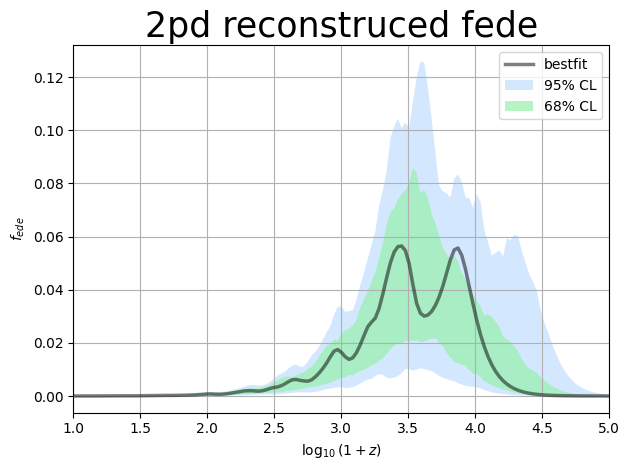

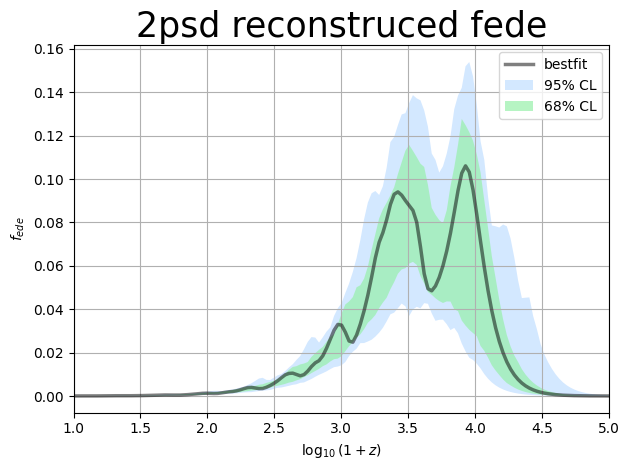

In [83]:
plt.plot(np.log10(1 + all_z_2pd[0]), f_ede_2pd, color='black',alpha=0.5, lw=2.5, label="bestfit")
# 95% confidence interval
# 68% confidence interval
# Median line
plt.fill_between(np.log10(1 + all_z_2pd[0]), ci_fede_2pd[0], ci_fede_2pd[3], alpha=0.4,label="95% CL")
plt.fill_between(np.log10(1 + all_z_2pd[0]), ci_fede_2pd[1], ci_fede_2pd[2], alpha=0.7, label="68% CL")

plt.xlabel(r"$\log_{10}(1+z)$")
#plt.yscale('log')
plt.ylabel(r"$f_{ede}$")
plt.xlim(1,5)
plt.title(r"2pd reconstruced fede", fontsize=25)
#plt.ylim(1e1,1e4)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(np.log10(1 + all_z_2psd[0]), f_ede_2psd, color='black',alpha=0.5, lw=2.5, label="bestfit")
# 95% confidence interval
# 68% confidence interval
# Median line
plt.fill_between(np.log10(1 + all_z_2psd[0]), ci_fede_2psd[0], ci_fede_2psd[3], alpha=0.4,label="95% CL")
plt.fill_between(np.log10(1 + all_z_2psd[0]), ci_fede_2psd[1], ci_fede_2psd[2], alpha=0.7, label="68% CL")

plt.xlabel(r"$\log_{10}(1+z)$")
#plt.yscale('log')
plt.ylabel(r"$f_{ede}$")
plt.xlim(1,5)
plt.title(r"2psd reconstruced fede", fontsize=25)
#plt.ylim(1e1,1e4)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [84]:
# -----------------------------
#2pd
# -----------------------------
data_dir = "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/1pd/output_class/"
dir = Path(data_dir)  # adjust path if needed
bf_file = data_dir+ "bestfit.npz"

lower_95_1pd, lower_68_1pd, upper_68_1pd, upper_95_1pd = extract_residuals(dir)
all_z_1pd, ci_fede_1pd, ci_h_1pd = extract_bg(dir)

residuals_bf_1pd, residuals_bf_H_1pd, f_ede_1pd  = extract_bf(bf_file)

# -----------------------------
#2psd
# -----------------------------
data_dir = "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/1psd/output_class/"
dir = Path(data_dir)  # adjust path if needed
bf_file =data_dir+ "bestfit.npz"

lower_95_1psd, lower_68_1psd, upper_68_1psd, upper_95_1psd = extract_residuals(dir)
residuals_bf_1psd, residuals_bf_H_1psd, f_ede_1psd  = extract_bf(bf_file)
all_z_1psd, ci_fede_1psd, ci_h_1psd = extract_bg(dir)

/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_36750/2492502995.py:91: RuntimeWarning: invalid value encountered in divide
  residuals = (D_tt_all - D_ell_0 )/ D_ell_0
/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_36750/2492502995.py:146: RuntimeWarning: invalid value encountered in divide
  residuals_bf = (D_tt_bf - D_ell_0 )/ D_ell_0  # ΔD_ell = sample - LCDM


<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

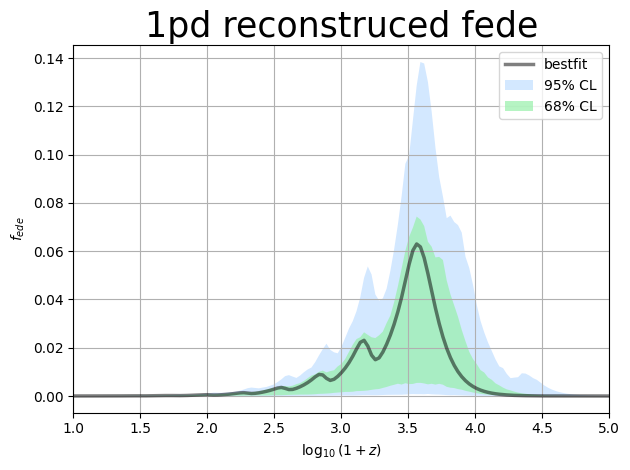

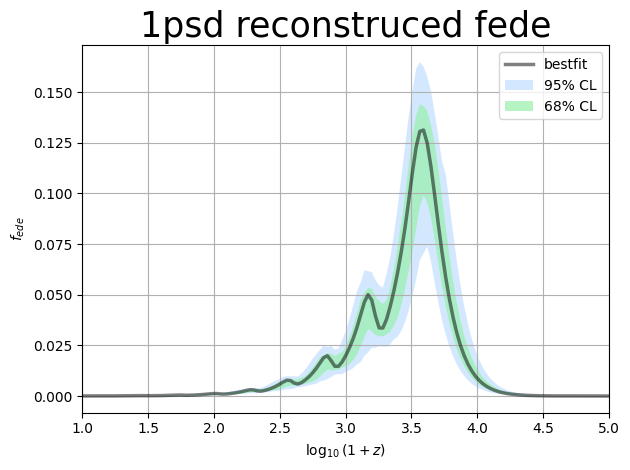

In [85]:
plt.plot(np.log10(1 + all_z_1pd[0]), f_ede_1pd, color='black',alpha=0.5, lw=2.5, label="bestfit")
# 95% confidence interval
# 68% confidence interval
# Median line
plt.fill_between(np.log10(1 + all_z_1pd[0]), ci_fede_1pd[0], ci_fede_1pd[3], alpha=0.4,label="95% CL")
plt.fill_between(np.log10(1 + all_z_1pd[0]), ci_fede_1pd[1], ci_fede_1pd[2], alpha=0.7, label="68% CL")

plt.xlabel(r"$\log_{10}(1+z)$")
#plt.yscale('log')
plt.ylabel(r"$f_{ede}$")
plt.xlim(1,5)
plt.title(r"1pd reconstruced fede", fontsize=25)
#plt.ylim(1e1,1e4)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(np.log10(1 + all_z_1psd[0]), f_ede_1psd, color='black',alpha=0.5, lw=2.5, label="bestfit")
# 95% confidence interval
# 68% confidence interval
# Median line
plt.fill_between(np.log10(1 + all_z_1psd[0]), ci_fede_1psd[0], ci_fede_1psd[3], alpha=0.4,label="95% CL")
plt.fill_between(np.log10(1 + all_z_1psd[0]), ci_fede_1psd[1], ci_fede_1psd[2], alpha=0.7, label="68% CL")

plt.xlabel(r"$\log_{10}(1+z)$")
#plt.yscale('log')
plt.ylabel(r"$f_{ede}$")
plt.xlim(1,5)
plt.title(r"1psd reconstruced fede", fontsize=25)
#plt.ylim(1e1,1e4)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


$N_\text{mscf}=1$, $\mathcal{D}_\text{pd}^\prime$
$N_\text{mscf}=1$, $\mathcal{D}_\text{psd}^\prime$
$N_\text{mscf}=2$, $\mathcal{D}_\text{pd}^\prime$
$N_\text{mscf}=2$, $\mathcal{D}_\text{psd}^\prime$


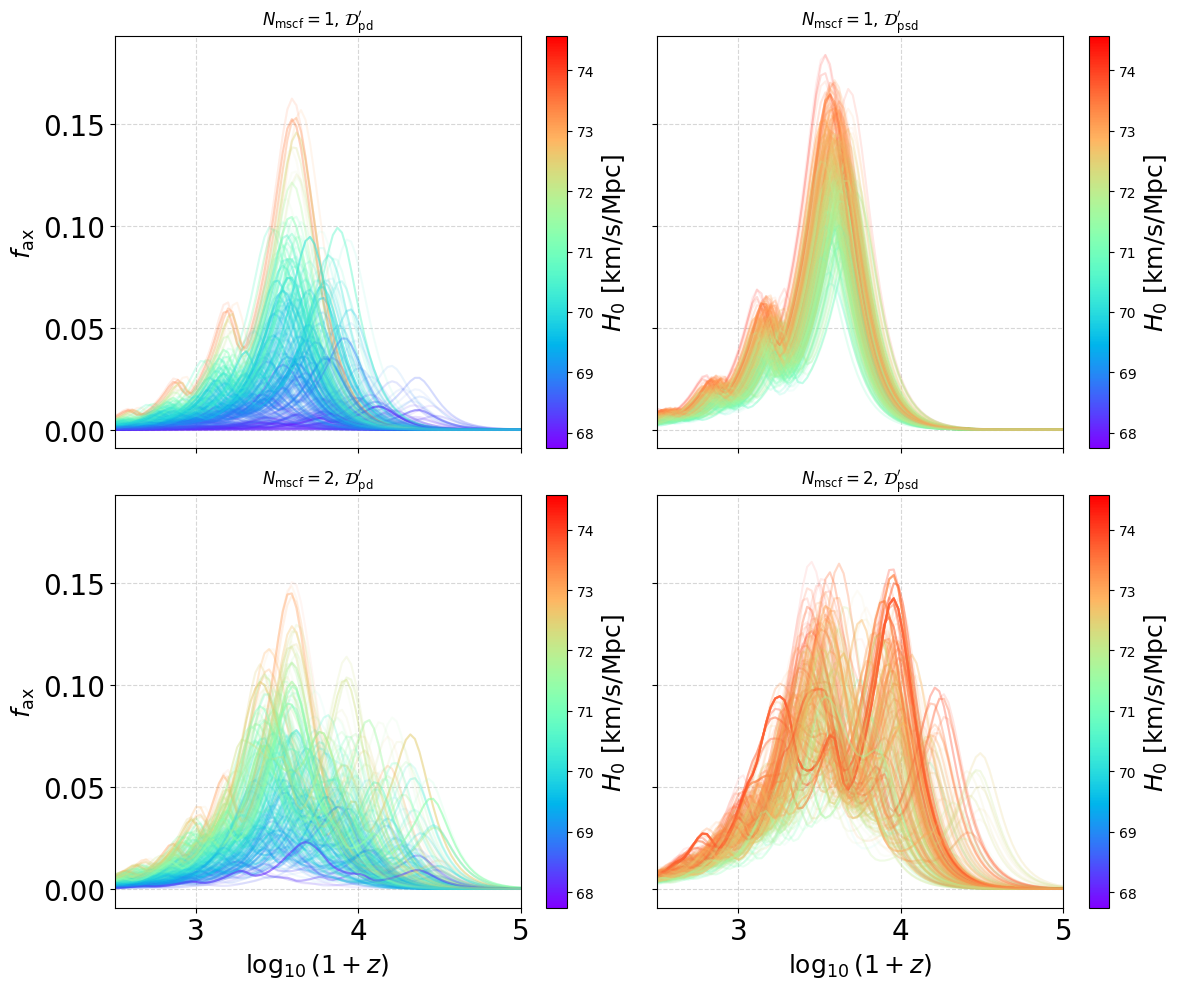

Saved rainbows.pdf to /Users/bellamarco01/uni/1_master_thesis/thesis/plots


In [97]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.colors as colors

data_dirs = ["/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/1pd/output_class/",
             "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/1psd/output_class/",
             "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/2pd/output_class/",
             "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/2psd/output_class/"]
titles = [
    r'$N_\text{mscf}=1$, $\mathcal{D}_\text{pd}^\prime$',
    r'$N_\text{mscf}=1$, $\mathcal{D}_\text{psd}^\prime$',
    r'$N_\text{mscf}=2$, $\mathcal{D}_\text{pd}^\prime$',
    r'$N_\text{mscf}=2$, $\mathcal{D}_\text{psd}^\prime$'
]

# ---- compute GLOBAL H0 limits for consistent colormap ----
H0_min = np.inf
H0_max = -np.inf

for data_dir in data_dirs:
    dir = Path(data_dir)
    npz_files = sorted(dir.glob("*_sample_*.npz"))
    for npz_file in npz_files:
        data = np.load(npz_file)
        H0 = data["H"][-1] * 299792
        H0_min = min(H0_min, H0)
        H0_max = max(H0_max, H0)

import plotting.plotting as pl
fig,axs = pl.new_fig(figsize=[12,10],ncols=2,nrows=2)
for i in [0,1,2,3]:
    data_dir = data_dirs[i]
    ax = axs[i]
    dir = Path(data_dir)
    npz_files = sorted(dir.glob("*_sample_*.npz"))

    all_z = []
    all_fEDE = []
    weights = []
    all_H = []
    all_H0=[]

    # load data
    for npz_file in npz_files:
        data = np.load(npz_file)
        all_z.append(data["z"])
        all_fEDE.append(data["f_EDE"])
        weights.append(data["weight"])
        all_H.append(data["H"])
        all_H0.append(data["H"][-1] * 299792)

    # print(all_H0)
    all_H0 = np.array(all_H0)
    weights = np.array(weights)

    # normalize weights to [0.05, 1] so no lines are invisible
    weights_norm = 0.05 + 0.55 * (weights / weights.max())
    # colormap: let's use viridis
    # norm = colors.Normalize(vmin=all_H0.min(), vmax=all_H0.max())
    norm = colors.Normalize(vmin=H0_min, vmax=H0_max)

    cmap = cm.rainbow

    # plot f_EDE(z) with alpha weighted by the sample weight
    for j, fEDE in enumerate(all_fEDE):
        ax.plot(np.log10(1+all_z[j]), fEDE, color=cmap(norm(all_H0[j])), alpha=weights_norm[j])

    # create colorbar attached to this ax
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # required for ScalarMappable

    cbar = fig.colorbar(sm, ax=ax)  # attach colorbar to our ax
    cbar.set_label(r"$H_0$ [km/s/Mpc]",fontsize=18)
    ax.set_title(titles[i],fontsize=18)

axs[0].set_ylabel(r"$f_\text{ax}$",fontsize=18)
axs[2].set_ylabel(r"$f_\text{ax}$",fontsize=18)
axs[2].set_xlabel(r"$\log_{10} (1+z)$",fontsize=18)
axs[3].set_xlabel(r"$\log_{10} (1+z)$",fontsize=18)
plt.xscale("linear")
plt.yscale("linear")
plt.xlim(2.5,5)
plt.tight_layout()
plt.show()
fig.save("rainbows")


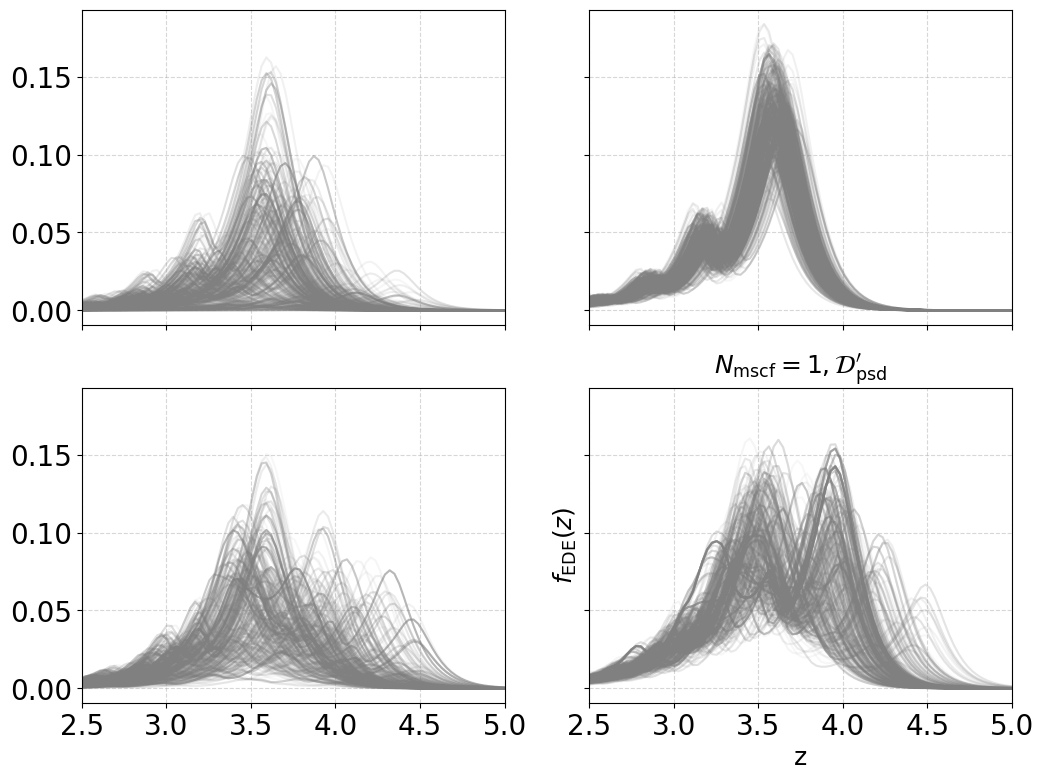

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.colors as colors

data_dirs = ["/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/1pd/output_class/",
             "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/1psd/output_class/",
             "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/2pd/output_class/",
             "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/2psd/output_class/"]
data_dir = "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/1psd/output_class/"

import plotting.plotting as pl
fig,axs = pl.new_fig(figsize=[12,9],ncols=2,nrows=2)
for i in [0,1,2,3]:
    data_dir = data_dirs[i]
    ax = axs[i]
    dir = Path(data_dir)
    npz_files = sorted(dir.glob("*_sample_*.npz"))

    all_z = []
    all_fEDE = []
    weights = []
    all_H = []
    all_H0=[]

    # load data
    for npz_file in npz_files:
        data = np.load(npz_file)
        all_z.append(data["z"])
        all_fEDE.append(data["f_EDE"])
        weights.append(data["weight"])
        all_H.append(data["H"])
        all_H0.append(data["H"][-1] * 299792)

    # print(all_H0)
    all_H0 = np.array(all_H0)
    weights = np.array(weights)

    # normalize weights to [0.05, 1] so no lines are invisible
    weights_norm = 0.05 + 0.55 * (weights / weights.max())
    # colormap: let's use viridis
    norm = colors.Normalize(vmin=all_H0.min(), vmax=all_H0.max())
    cmap = cm.rainbow

    # plot f_EDE(z) with alpha weighted by the sample weight
    for i, fEDE in enumerate(all_fEDE):
        ax.plot(np.log10(1+all_z[i]), fEDE, color='grey', alpha=weights_norm[i])

    # create colorbar attached to this ax
    # sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    # sm.set_array([])  # required for ScalarMappable

    # cbar = fig.colorbar(sm, ax=ax)  # attach colorbar to our ax
    # cbar.set_label(r"$H_0$ [km/s/Mpc]")

plt.xlabel("z",fontsize=18)
plt.ylabel(r"$f_\mathrm{EDE}(z)$",fontsize=18)
plt.title(r"$N_\text{mscf}=1,\mathcal{D}^\prime_\text{psd}$",fontsize=18)
plt.xscale("linear")
plt.yscale("linear")
plt.xlim(2.5,5)
# plt.tight_layout()
plt.show()
